# TensorFlow Variational Autoencoder

## 使用VAE來做手寫辨識
## 進行encode, decode

In [406]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [407]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from ipywidgets import interact, FloatSlider

In [408]:
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

from tensorflow.keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras import backend as K

## 從mnist資料庫讀入所有資料

In [409]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [410]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

minval = x_train.min()
maxval = x_train.max()

x_train -= minval
x_train = x_train / maxval

## Define Autoencoder Properties

In [411]:
x = Input(shape=(784,))
encoder_1 = Dense(100, activation='relu')
encoder_2 = Dense(2, activation='relu')
# Second layer has 2 neurons to reflect an autoencoder

h = encoder_2(encoder_1(x))

decoder_2 = Dense(100, activation='relu')
decoder_1 = Dense(784, activation='sigmoid')

x_hat = decoder_1(decoder_2(h))

In [412]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_87 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_88 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_89 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_90 (Dense)             (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [413]:
ep = input("Enter number of epochs for autoencoder: ")
ep = int(ep)

Enter number of epochs for autoencoder: 50


In [414]:
batch_size = 1024

In [415]:
autoencoder.compile(loss='mse', optimizer=Adam())
autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=ep)

Epoch 1/50
60000/60000 [==============================] - 2s 26us/sample - loss: 0.1149
Epoch 2/50
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0699
Epoch 3/50
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0643
Epoch 4/50
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0613
Epoch 5/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0597
Epoch 6/50
60000/60000 [==============================] - 1s 24us/sample - loss: 0.0584
Epoch 7/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0572
Epoch 8/50
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0561
Epoch 9/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0553
Epoch 10/50
60000/60000 [==============================] - 2s 25us/sample - loss: 0.0547
Epoch 11/50
60000/60000 [==============================] - 1s 25us/sample - loss: 0.0542
Epoch 12/50
60000/60000 [=====

In [416]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

In [417]:
Encoder = Model(x, h)
Encoder.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_87 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_88 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [418]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, decoder_1(decoder_2(h_input)))

Decoder.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_89 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_90 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## Visualise Encoder

In [419]:
idx = np.random.randint(x_train.shape[0])
print("The latent value at index %d is %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

The latent value at index 39908 is [[0.        5.7026205]]


In [420]:
indices = np.random.randint(x_test.shape[0], size=3000)

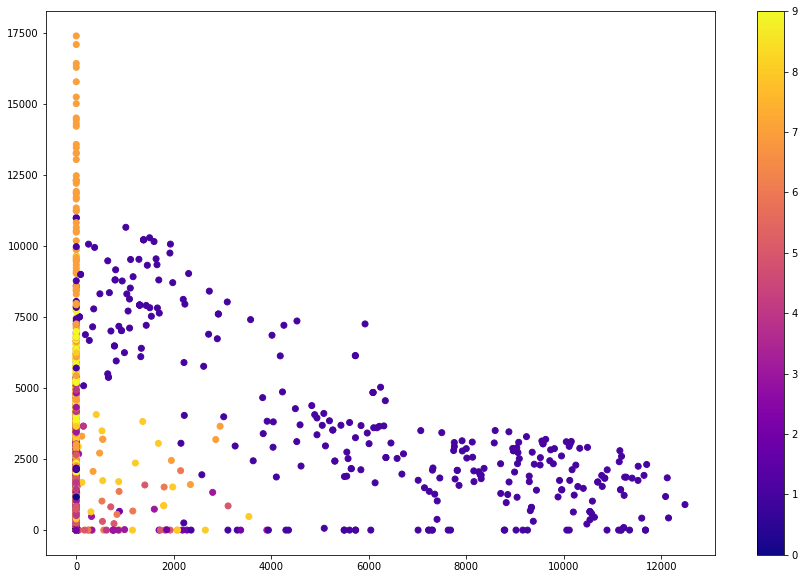

In [421]:
latents = Encoder.predict(x_test[indices])
plt.figure(figsize=(15,10))
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="plasma")
plt.colorbar()
plt.show()

## Visualise Decoder

In [422]:
def normalized(n):
    n -= n.min()
    n /= n.max()
    return n

In [447]:
n = 20
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [448]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = normalized(digit)

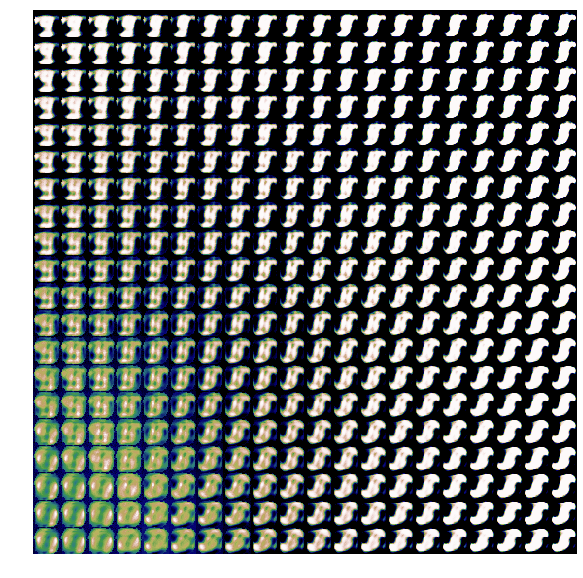

In [449]:
plt.figure(figsize=(10,10))
plt.imshow(figure,cmap='gist_earth')
plt.axis('off')
plt.show()

## Create the Variational Autoencoder (VAE)

In [426]:
encoder_1 = Dense(100, activation = 'sigmoid')

encoder_mean = Dense(2)
encoder_log_var = Dense(2)

In [427]:
decoder_2 = Dense(100, activation='sigmoid')
decoder_1 = Dense(784, activation='sigmoid')

In [428]:
x = Input(shape=(784,))
encoder_x = encoder_1(x)

z_mean = encoder_mean(encoder_x)
z_log_var = encoder_log_var(encoder_x)

In [429]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var/2) * epsilon

In [430]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [431]:
decoder_x = decoder_2(z)
x_hat = decoder_1(decoder_x)

In [432]:
VAE = Model(x, x_hat)
#VAE.summary()

## Define Loss Function

In [433]:
def vae_loss(x, x_recon):
    recovery_loss = 784*metrics.binary_crossentropy(x, x_recon)
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

## Train the Variational Autoencoder

In [434]:
ep = input("Enter number of epochs for Variational autoencoder: ")
ep = int(ep)

Enter number of epochs for Variational autoencoder: 50


In [435]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=32, epochs=ep)
#VAE.save_weights('VAE_handwriting_model_weights.h5')
#VAE.load_weights('VAE_handwriting_model_weights.h5')

Epoch 1/50
60000/60000 [==============================] - 6s 92us/sample - loss: 195.9209
Epoch 2/50
60000/60000 [==============================] - 5s 86us/sample - loss: 181.0006
Epoch 3/50
60000/60000 [==============================] - 5s 81us/sample - loss: 178.6093
Epoch 4/50
60000/60000 [==============================] - 5s 82us/sample - loss: 175.5420
Epoch 5/50
60000/60000 [==============================] - 5s 83us/sample - loss: 171.7057
Epoch 6/50
60000/60000 [==============================] - 5s 80us/sample - loss: 168.2657
Epoch 7/50
60000/60000 [==============================] - 5s 90us/sample - loss: 165.9884
Epoch 8/50
60000/60000 [==============================] - 5s 84us/sample - loss: 164.3500
Epoch 9/50
60000/60000 [==============================] - 5s 80us/sample - loss: 163.0682
Epoch 10/50
60000/60000 [==============================] - 6s 96us/sample - loss: 161.7105
Epoch 11/50
60000/60000 [==============================] - 5s 88us/sample - loss: 160.4410
Epoch 12

In [436]:
VAE_Encoder = Model(x, z_mean)
#VAE_Encoder.summary()

In [437]:
VAE_Decoder = Model(h_input, decoder_1(decoder_2(h_input)))
#VAE_Decoder.summary()

In [438]:
idx = np.random.randint(x_train.shape[0])

In [439]:
VAE_latents = VAE_Encoder.predict(x_test[indices])

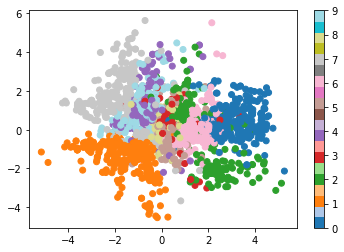

In [440]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [441]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [442]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size*n, digit_size*n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1)*digit_size: (n-i)*digit_size,
                  j*digit_size: (j+1) * digit_size] - normalized(digit)

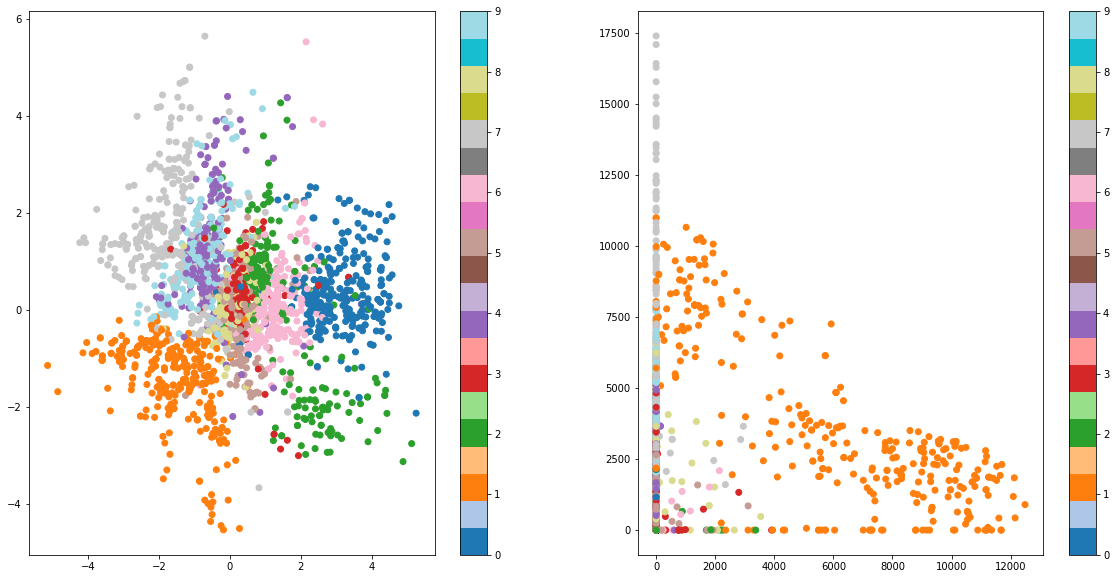

In [443]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [444]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1
    
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(2,1,2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])
    
    ax2 = plt.subplot(2,3,1)
    ax2.imshow(data_0, cmap='Purples')
    
    ax3 = plt.subplot(2,3,2)
    ax3.imshow(data_t, cmap='bone') # took suggestion from 子偉
                                    # bone cmap for contrast
    
    ax4 = plt.subplot(2,3,3)
    ax4.imshow(data_1, cmap='Purples')

In [445]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [450]:
interact(inBetween, t=FloatSlider(value=0.0,
                                 min= 0.0, max=1.0,
                                 step = 0.1,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.inBetween(t)>

#### Sources
    政大魔法程式家
        助教
        Chieh Chang
        子偉
        諭宣
    Keras samples
    Ahlad Kumar